# Loading packages

In [1]:
import numpy as np
import pandas as pd
import glob

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pandas.api.types import CategoricalDtype

# Loading data

In [4]:
data= pd.read_pickle("../data/modified_exclusions/pt_replication_modified_exclusions_data.pkl")

In [5]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,Loss_Intuition,Country,Duration_in_seconds,Language,Sample,Duration_Minutes,YoB,Awareness_of_Loss_Aversion,Financial_Stress,Presentation_Order
0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,Bulgaria,356,Bulgarian,Direct,5.933333,1992,3,NaN,4|6|2|3|17|18|14|8|7|15|1|12|11|5|13|16|9|10
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,Bulgaria,931,Bulgarian,Direct,15.516667,1979,1,NaN,7|17|16|11|15|18|4|9|1|13|2|10|6|14|5|12|8|3
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,Bulgaria,462,Bulgarian,Direct,7.700000,1975,3,NaN,11|8|4|7|12|18|3|14|6|16|17|1|2|13|5|15|9|10
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,NaN,Bulgaria,412,Bulgarian,Direct,6.866667,1977,1,NaN,16|7|6|9|12|18|10|8|5|15|2|3|4|14|11|1|17|13
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,Bulgaria,490,Bulgarian,Direct,8.166667,1970,1,NaN,13|4|3|7|9|18|16|8|14|1|6|12|17|10|5|2|11|15


### Simulations

In [7]:
from scipy.stats import chisquare

In [9]:
%%time
np.random.seed(357) ### This is the seed specified in the prereg

for col in [str(x) for x in np.arange(1, 18)]:
    org_sample = data.loc[:, col]
    org_n = org_sample.shape[0]
    sims = pd.DataFrame(np.random.choice(org_sample, replace=True, size=(org_n, 100000)))
    sim_means = sims.mean(0)
    sim_a = sims.sum(0)
    sim_b = org_n - sims.sum(0)
    sim_contingencies = pd.DataFrame([sim_a, sim_b]).transpose()
    sim_p_values = sim_contingencies.apply(lambda x: chisquare(x), axis=1).apply(pd.Series)[1]
    sim_significance = (sim_p_values < 0.001)
    if col == "1":
        sim_data = pd.DataFrame([sim_means, sim_p_values, sim_significance]).transpose()
        sim_data.columns = ["Proportion A", "p-value", "significance"]
        sim_data["Item"] = col
    else:
        sim_df = pd.DataFrame([sim_means, sim_p_values, sim_significance]).transpose()
        sim_df.columns = ["Proportion A", "p-value", "significance"]
        sim_df["Item"] = col
        sim_data = pd.concat([sim_data, sim_df], axis=0, ignore_index=True)

Wall time: 13min 13s


In [11]:
long_data = data.groupby("Country")[[str(i) for i in np.arange(1, 18)]].mean().reset_index().melt(id_vars="Country", value_vars=[str(i) for i in np.arange(1, 18)],
                                                                                     var_name="Item", value_name="Proportion")

In [16]:
empirical_proportions = data[[str(i) for i in np.arange(1, 18)]].mean()

Wall time: 6.66 s


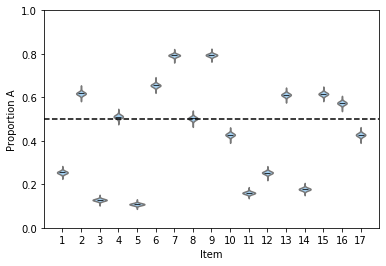

In [28]:
%%time
fig, ax = plt.subplots()
sns.violinplot(data=sim_data, x="Item", y="Proportion A", ax=ax,
              order=[str(x) for x in np.arange(1, 18)],
              color='#95d0fc', inner=None)
sns.scatterplot(x=empirical_proportions.index, y=empirical_proportions.values,
                    color="Black", s=30, marker="_")
ax.axhline(ls='--', c="black", y=0.5)
ax.set(ylim=(0, 1))
plt.savefig("../figures/supplement/bootstrapped_effects.svg")

In [29]:
%%time
sim_data["Sign"] = (sim_data["Proportion A"] - 0.5).apply(np.sign)

Wall time: 14 ms


In [31]:
original_pt_proportions = pd.Series([0.18, 0.83, 0.20, 0.65, 0.14, 0.73, 0.92, 0.42, 0.92, 0.30, 0.22, 0.16, 0.69, 0.18, 0.70, 0.72, 0.17],
                                   index=[str(i) for i in np.arange(1, 18)])
original_pt_proportions

1     0.18
2     0.83
3     0.20
4     0.65
5     0.14
6     0.73
7     0.92
8     0.42
9     0.92
10    0.30
11    0.22
12    0.16
13    0.69
14    0.18
15    0.70
16    0.72
17    0.17
dtype: float64

In [32]:
original_pt_differences_from_chance = original_pt_proportions - 0.5

In [33]:
original_pt_sign = original_pt_differences_from_chance.apply(np.sign)

In [37]:
%%time
sim_data["Sign Difference"] = np.nan
for i in [str(x) for x in np.arange(1, 18)]:
    sim_data.loc[sim_data["Item"]==i, "Sign Difference"] = sim_data.loc[sim_data["Item"]==i, "Sign"] != original_pt_sign[i]

Wall time: 3.96 s


In [38]:
%%time
sim_data["Succesful Replication"] = np.nan
sim_data.loc[(sim_data["Sign Difference"] == False) & (sim_data["p-value"]<0.001), "Succesful Replication"] = True
sim_data.loc[(sim_data["Sign Difference"] == False) & (sim_data["p-value"]>0.001), "Succesful Replication"] = False
sim_data.loc[(sim_data["Sign Difference"] == True), "Succesful Replication"] = False
sim_data.loc[(sim_data["Item"]=="8"), "Succesful Replication"] = np.nan

Wall time: 532 ms


In [39]:
sim_data["Succesful Replication"].astype(float).mean()

0.9397675

In [40]:
sim_data["Succesful Replication Number"] = sim_data["Succesful Replication"].astype(float)

In [41]:
simulated_replication_rates = sim_data.groupby("Item")["Succesful Replication Number"].mean()[[str(x) for x in np.arange(1, 18)]]

In [42]:
simulated_replication_rates

Item
1     1.00000
2     1.00000
3     1.00000
4     0.03628
5     1.00000
6     1.00000
7     1.00000
8         NaN
9     1.00000
10    1.00000
11    1.00000
12    1.00000
13    1.00000
14    1.00000
15    1.00000
16    1.00000
17    1.00000
Name: Succesful Replication Number, dtype: float64

### Assuming that our sample is somewhat representative of the population, all items are very likely to replicate in China, apart from Items 10 & 17, which is unlikely to replicate in China. This provides support for the idea that explicitly mentioning the 0s modify the effects of extreme probabilities

In [44]:
simulated_replication_rates.to_excel("../Supplementary Tables/Simulated Replication Rates - Global.xlsx")

In [45]:
sim_data.to_pickle("../Simulations/Global.pkl")

In [46]:
del sim_data